In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
from keras.models import Model
import os
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from IPython.display import clear_output
import xgboost as xgb
import gc

In [2]:
def extract_raw_data(dirname, size):
    train_images = []
    for fname in os.listdir(dirname):
        img = cv2.imread(os.path.join(dirname, fname), cv2.IMREAD_GRAYSCALE) 
        if img is None:
            print(f"Warning: Could not read image {fname} from {dirname}")
            continue 
        img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
        train_stack = np.stack((img,)*3, axis=-1)
        train_images.append(train_stack)   
    return np.array(train_images)

def extract_label_data(dirname, size):
    train_masks = [] 
    for fname in os.listdir(dirname):
        img = cv2.imread(os.path.join(dirname, fname), cv2.IMREAD_GRAYSCALE)    
        if img is None:
            print(f"Warning: Could not read image {fname} from {dirname}")
            continue     
        img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
        train_masks.append(img)
        
    return np.array(train_masks)
def split_data_set_gray_scale(dirname_data, dirname_label, test_size, picture_size):

    X_train, X_test, y_train, y_test = train_test_split(extract_raw_data(dirname_data,picture_size), extract_label_data(dirname_label,picture_size), test_size=test_size, random_state=42)
    
    y_train = np.expand_dims(y_train, axis=3) 
    y_test = np.expand_dims(y_test, axis=3)
    
    return X_train, X_test, y_train, y_test

def features_2_dataframe(features):

    X=features
    X = X.reshape(-1, X.shape[3]) 
    Y = y_train.reshape(-1)
    dataframe = pd.DataFrame(X)
    dataframe['Label'] = Y
    return dataframe

def get_VGG_model_features(train_data_X, size):
    VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(size[0], size[1], 3))
    #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
    for layer in VGG_model.layers:
        layer.trainable = False
    VGG_model.summary()  #Trainable parameters will be 0
    #After the first 2 convolutional layers the image dimension changes so we take the features vectors after first two layers
    #Load VGG16 model wothout classifier/fully connected layers
    #Talked to the professor and as it seems the input shape makes sure that we can actually run pooling and kernal operations
    VGG_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
    VGG_model.summary()
    features = VGG_model.predict(train_data_X)
    
    return features, features_2_dataframe(features), VGG_model

def plot_VGG_features(features):
    square = 8
    ix=1
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(features[0,:,:,ix-1], cmap='gray')
            ix +=1
    plt.show()

<h3>Get features with VGG Net Pretrained weights and plot the features</h3>

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 501, 501, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 501, 501, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 501, 501, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 125, 125, 128)     0     

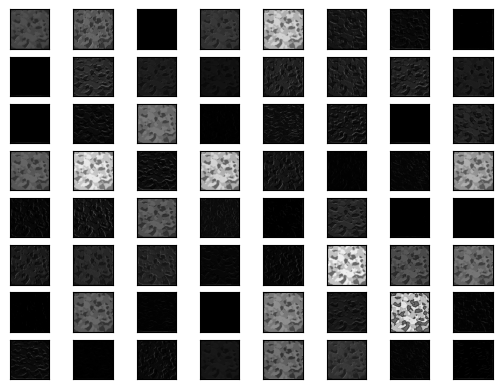

In [15]:
#Get Data
X_train, X_test, y_train, y_test = split_data_set_gray_scale('./dataset/data','./dataset/labels', 0.95, [501, 501])
#Train weights
features,dataset,VGG_model = get_VGG_model_features(X_train,[501,501])
#Plot features
plot_VGG_features(features)

<h3>Prepare Data for Trainig

In [8]:
#Prepare data for training
dataset = dataset.sample(frac=0.005, random_state=1)
#Redefine X and Y for Random Forest
X_for_training = dataset.drop(labels = ['Label'], axis=1)
X_for_training = X_for_training.values  #Convert to array
Y_for_training = dataset['Label']
Y_for_training = Y_for_training.values  #Convert to array
mapping = {0: 0, 128: 1, 255: 2}
# Vectorized mapping
Y_for_training = np.vectorize(mapping.get)(Y_for_training)

<h3>Train XGBoost Model</h3>

In [ ]:
model = xgb.XGBClassifier()
# Train the model on training data
model.fit(X_for_training, Y_for_training) 
#Save model for future use
filename = 'model_XGBoost.sav'
pickle.dump(model, open(filename, 'wb'))


<h3>Train NN Model</h3>

Question is if i can use more data here in the training, than in XGBoost Network?

In [12]:
# Define the neural network architecture
class SimpleNN(tf.keras.Model):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = layers.Dense(128, activation='relu')  # Adjust input dimensions if needed
        self.fc2 = layers.Dense(3)  # Adjust output dimensions based on the number of classes

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x


def train_simple_nn(epoches, X, Y, model_filename):
    # Convert the data to TensorFlow tensors
    X_train_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    Y_train_tensor = tf.convert_to_tensor(Y, dtype=tf.int64)

    # Create a TensorFlow Dataset and a DataLoader
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, Y_train_tensor))
    train_loader = train_dataset.shuffle(buffer_size=10000).batch(32)

    # Initialize the model
    model = SimpleNN()

    # Define loss function and optimizer
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Metrics to track loss
    train_loss = tf.keras.metrics.Mean(name='train_loss')

    # Training function
    @tf.function
    def train_step(images, labels):
        with tf.GradientTape() as tape:
            predictions = model(images, training=True)
            loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

    # Train the model
    best_loss = float('inf')

    for epoch in range(epoches):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        
        for inputs, labels in train_loader:
            train_step(inputs, labels)

        current_loss = train_loss.result()
        if current_loss < best_loss:
            best_loss = current_loss
            model.save_weights(f"{model_filename}.h5")
            print(f'New best model saved with loss: {best_loss:.4f}')

        print(f'Epoch {epoch + 1}, Loss: {current_loss:.4f}')

In [ ]:
#Train NN 
train_simple_nn(10, X_for_training, Y_for_training, 'NN_Model_VGG_Features_V01')

<h3>Load the Models</h3>

In [13]:
#Load Boost Model
filename = 'model_XGBoost.sav'
loaded_model_XGB = pickle.load(open(filename, 'rb'))
#Load NN Model
model_NN = SimpleNN()  # Replace with your actual model architecture
sample_input = tf.random.normal([1, 64])  # Replace 'input_shape' with the shape of your model input
model_NN(sample_input)
# Load the weights
model_NN.load_weights('NN_Model_VGG_Features.h5')

<h3>Probabilities if Pixels</h3>

<h3>Plot the results for the first Image</h3>

In [16]:
image_to_plot = 5

image = np.expand_dims(X_test[image_to_plot], axis=0)  # Reshape to (1, 501, 501, 3)
X_test_feature = VGG_model.predict(image)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

#Predict XGBoost Image
prediction = loaded_model_XGB.predict(X_test_feature)
prediction_image = prediction.reshape((501, 501))

#Original and labled Images
original_image = np.squeeze(X_test[image_to_plot])
labeled_images = np.squeeze(y_test[image_to_plot])  

#Probabilities
pred_probabilities = loaded_model_XGB.predict_proba(X_test_feature)
class_probabilities_df = pd.DataFrame(pred_probabilities, columns=[f'Class_{i+1}_Prob' for i in range(pred_probabilities.shape[1])])

#Lets get only the once where it is uncertain
filtered_df = class_probabilities_df[(class_probabilities_df < 0.6).all(axis=1)]



1/1 [==============================] - 0s 41ms/step


In [17]:
#Predict NN Image
feature_matrix = X_test_feature.reshape((501 * 501, -1))
# Convert to TensorFlow tensor
feature_tensor = tf.convert_to_tensor(feature_matrix, dtype=tf.float32)
# Predict with the model
prediction = model_NN(feature_tensor)  # model is your loaded and compiled neural network model
prediction = tf.nn.softmax(prediction, axis=1)  # As classification dont need softmax we have it here to get probabilities and take the one with the highest argument in the end
predicted_classes = tf.argmax(prediction, axis=1).numpy()
# Reshape the predictions back into image format
prediction_image_NN = predicted_classes.reshape((501, 501))

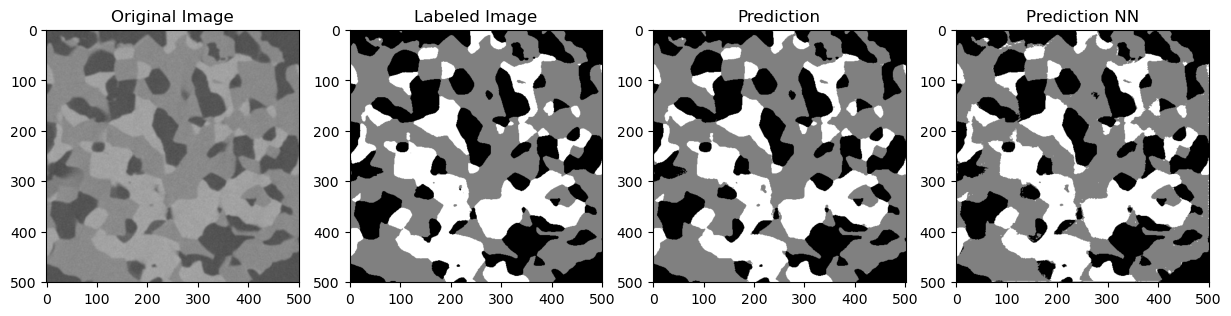

In [18]:
#Plot the different Images

plt.figure(figsize=(15, 5))  # Increase the figure size for better visibility

# Plot the original image
plt.subplot(1, 4, 1)  # 1 row, 3 columns, first subplot
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

# Plot the labeled image
plt.subplot(1, 4, 2)  # 1 row, 3 columns, second subplot
plt.imshow(labeled_images, cmap='gray')  # You might not need cmap='gray' if it's a color label image
plt.title('Labeled Image')

# Plot the prediction image
plt.subplot(1, 4, 3)  # 1 row, 3 columns, third subplot
plt.imshow(prediction_image, cmap='gray')
plt.title('Prediction')

# Plot the prediction image
plt.subplot(1, 4, 4)  # 1 row, 3 columns, third subplot
plt.imshow(prediction_image_NN, cmap='gray')
plt.title('Prediction NN')

# Show the plot
plt.show()

In [24]:
def preprocess_image(image):
    """Preprocesses the image for model prediction."""
    return np.expand_dims(image, axis=0)



def predict_with_nn(nn_model, image):
    # Get features from VGG model
    feature_matrix = VGG_model.predict(image)
    feature_matrix = feature_matrix.reshape((501 * 501, -1))

    # Convert to TensorFlow tensor
    feature_tensor = tf.convert_to_tensor(feature_matrix, dtype=tf.float32)
    # Predict with the model
    prediction = nn_model(feature_tensor)  # model is your loaded and compiled neural network model
    prediction = tf.nn.softmax(prediction, axis=1)  # As classification dont need softmax we have it here to get probabilities and take the one with the highest argument in the end
    predicted_classes = tf.argmax(prediction, axis=1).numpy()

    # Reshape the predictions back into image format
    prediction_image_NN = predicted_classes.reshape((501, 501))
    return prediction_image_NN

def predict_with_xgb( xgb_model, image):
    feature_matrix = VGG_model.predict(image)
    feature_matrix = feature_matrix.reshape(-1, feature_matrix.shape[3])
    prediction = xgb_model.predict(feature_matrix)
    prediction_image = prediction.reshape((501, 501))
    return prediction_image
    
def calculate_metrics(y_true, y_pred, class_values):
    y_pred_mapped = np.copy(y_pred)
    for class_index, class_value in enumerate(class_values):
        y_pred_mapped[y_pred == class_index] = class_value

    y_true_flatten = y_true.flatten()
    y_pred_flatten = y_pred_mapped.flatten()

    # Calculate metrics
    accuracy = accuracy_score(y_true_flatten, y_pred_flatten)
    
    # For a multi-class problem, change 'binary' to 'macro' (unweighted average), 'micro' (global average), or 'weighted' (weighted average)
    precision = precision_score(y_true_flatten, y_pred_flatten, average='macro', labels=class_values)
    recall = recall_score(y_true_flatten, y_pred_flatten, average='macro', labels=class_values)
    f1 = f1_score(y_true_flatten, y_pred_flatten, average='macro', labels=class_values)
    iou = jaccard_score(y_true_flatten, y_pred_flatten, average='macro', labels=class_values)
    
    return accuracy, precision, recall, f1, iou

def compute_and_print_mean_metrics(metrics):
    """Computes and prints the mean of the given metrics."""
    mean_metrics = np.mean(metrics, axis=0)
    metric_names = ["Accuracy", "Precision", "Recall", "F1 Score", "IoU"]

    for name, mean_metric in zip(metric_names, mean_metrics):
        print(f'Mean {name}: {mean_metric}')

# Initialize lists to store metric scores for each image for both models
nn_metrics, xgb_metrics = [], []

for i in range(5):
    image = preprocess_image(X_test[i])

    # Predict with Neural Network and XGBoost models
    xgb_prediction = predict_with_xgb(loaded_model_XGB, image)

    nn_prediction = predict_with_nn(model_NN, image)

    # Convert prediction to the same format as ground truth, if necessary
    # Example: nn_prediction_converted = convert_format(nn_prediction)
    # Example: xgb_prediction_converted = convert_format(xgb_prediction)

    # Calculate metrics
    nn_metrics.append(calculate_metrics(y_test[i].flatten(), nn_prediction.flatten(),[0, 128, 255]))
    xgb_metrics.append(calculate_metrics(y_test[i].flatten(), xgb_prediction.flatten(),[0, 128, 255]))

    # Memory management
    if (i + 1) % 10 == 0:  # Clear memory every 10 iterations
        gc.collect()

# Print mean metrics for both models
print("Neural Network Model Metrics:")
compute_and_print_mean_metrics(nn_metrics)

print("\nXGBoost Model Metrics:")
compute_and_print_mean_metrics(xgb_metrics)



1/1 [==============================] - 0s 48ms/step
Neural Network Model Metrics:
Mean Accuracy: 0.9745108585224761
Mean Precision: 0.9720674979991466
Mean Recall: 0.9752859959195955
Mean F1 Score: 0.9736243092409727
Mean IoU: 0.9487344562871666

XGBoost Model Metrics:
Mean Accuracy: 0.9894159784223968
Mean Precision: 0.9895149139805218
Mean Recall: 0.9887047936989445
Mean F1 Score: 0.9891009052257885
Mean IoU: 0.9784568213564796


<h3>Second Data Set Model Performance</h3>

In [25]:
#Same Stuff as last Time, i should put it into a method for data extraktion

X_train, X_test, y_train, y_test = split_data_set_gray_scale('./dataset2/originalpng','./dataset2/mask2', 0.5, [759,759])
#We can set all train that are not 255 to zero

#I have to change all the values of the 
unique_values = np.unique(y_train)
print("Unique values in the array:", unique_values)
features,dataset,VGG_model_2 = get_VGG_model_features(X_train, [759,759])
#Now Train XGB and NN


Unique values in the array: [  0 255]
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 759, 759, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 759, 759, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 759, 759, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 379, 379, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 379, 379, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 379, 379, 128)     147584    
                                                                 
 block2_pool (MaxPoolin

In [26]:
#Prepare data for training
dataset = dataset.sample(frac=0.99, random_state=1)
#Redefine X and Y for Random Forest
X_for_training = dataset.drop(labels = ['Label'], axis=1)
X_for_training = X_for_training.values  #Convert to array
Y_for_training = dataset['Label']
Y_for_training = Y_for_training.values  #Convert to array
mapping = {0: 0, 255: 1}
# Vectorized mapping
Y_for_training = np.vectorize(mapping.get)(Y_for_training)

In [ ]:
model = xgb.XGBClassifier()
# Train the model on training data
model.fit(X_for_training, Y_for_training) 
#Save model for future use
filename = 'model_XGBoost2.sav'
pickle.dump(model, open(filename, 'wb'))

1/1 [==============================] - 0s 104ms/step


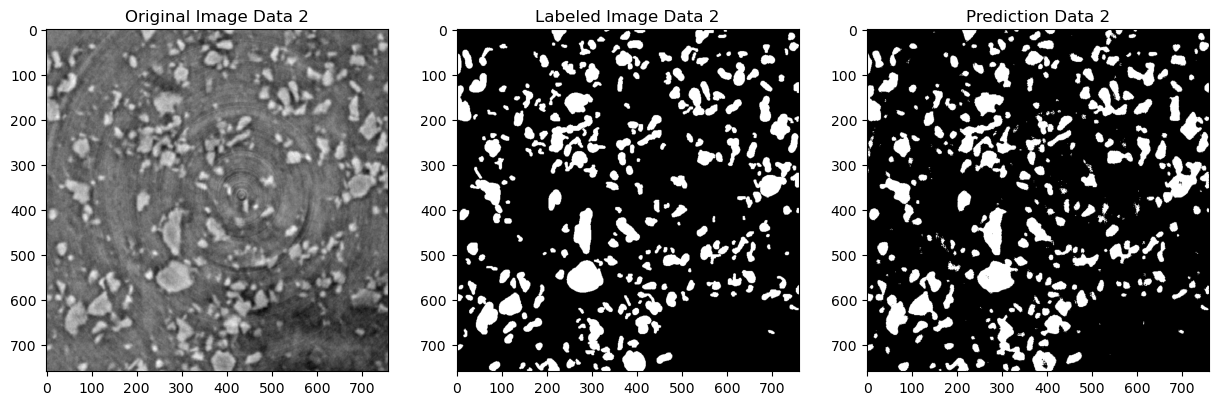

In [27]:
#Load Boost Model
filename = 'model_XGBoost2.sav'
loaded_model_XGB_2 = pickle.load(open(filename, 'rb'))

image_to_plot = 1

image = np.expand_dims(X_test[image_to_plot], axis=0)  # Reshape to (1, 501, 501, 3)
X_test_feature = VGG_model_2.predict(image)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

#Predict XGBoost Image
prediction = loaded_model_XGB_2.predict(X_test_feature)
prediction_image = prediction.reshape((759, 759))

#Original and labled Images
original_image = np.squeeze(X_test[image_to_plot])
labeled_images = np.squeeze(y_test[image_to_plot])  

#Plot the different Images

plt.figure(figsize=(15, 5))  # Increase the figure size for better visibility

# Plot the original image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
plt.imshow(original_image, cmap='gray')
plt.title('Original Image Data 2')

# Plot the labeled image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
plt.imshow(labeled_images, cmap='gray')  # You might not need cmap='gray' if it's a color label image
plt.title('Labeled Image Data 2')

# Plot the prediction image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
plt.imshow(prediction_image, cmap='gray')
plt.title('Prediction Data 2')
# Show the plot
plt.show()